Questo e' il primo modello, al momento quello migliore

# 🌍 SkyViewNet: Aerial Landscape Classification with CNN and MobileNet


##🌍Libraries

In [ ]:
import kagglehub
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import kagglehub

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##🌍Function

In [ ]:
#Funzione per la creazione del dataframe contentente i file e le etichette
def make_dataframe(path):
  filelist = []

  #Percorre il dataset e raccogli i percorsi delle immagini
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          filelist.append(os.path.join(dirname, filename))
  Filepaths = []
  labels = []
  #Divide i percorsi in etichette e immagini
  for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    Filepaths.append(image_file)
    labels.append(label)

  #Creazione del dataframe
  Fseries = pd.Series(Filepaths, name="Filepath")
  Lseries = pd.Series(labels, name="Label")
  df = pd.concat([Fseries, Lseries], axis=1)
  df = (df.sample(frac=1, random_state=42).reset_index()).drop(columns="index")
  return df

#Funzione per la visualizzazione della distribuzione delle immagini per ogni classe
def plot_class_distribution(df):
    # Calcola il numero di immagini per ciascuna classe
    class_counts = df['Label'].value_counts()

    # Crea il plot
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

    # Impostazioni del grafico
    plt.title('Distribuzione delle Classi nel Dataset', fontsize=16)
    plt.xlabel('Classe', fontsize=14)
    plt.ylabel('Numero di Immagini', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Mostra il grafico
    plt.show()
    print(df)

## 🌍 Data Import

The dataset used for this project was downloaded from the website:  
https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset


In [ ]:
#Download dell'ultima versione del dataset
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skyview-an-aerial-landscape-dataset


## 🌍 Data Analysis and Visualization


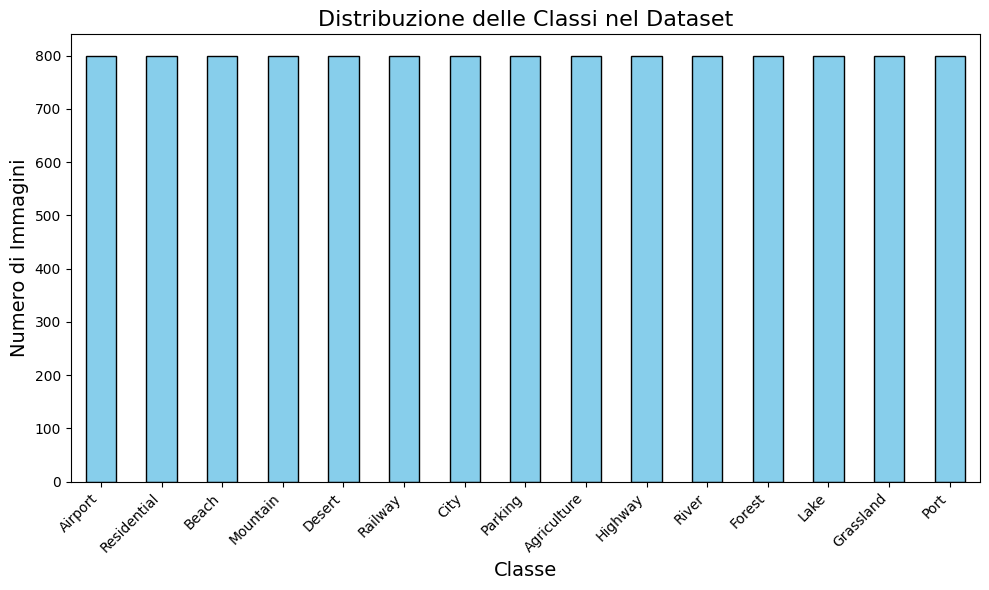

                                                Filepath        Label
0      /kaggle/input/skyview-an-aerial-landscape-data...      Airport
1      /kaggle/input/skyview-an-aerial-landscape-data...  Residential
2      /kaggle/input/skyview-an-aerial-landscape-data...      Airport
3      /kaggle/input/skyview-an-aerial-landscape-data...        Beach
4      /kaggle/input/skyview-an-aerial-landscape-data...     Mountain
...                                                  ...          ...
11995  /kaggle/input/skyview-an-aerial-landscape-data...    Grassland
11996  /kaggle/input/skyview-an-aerial-landscape-data...      Railway
11997  /kaggle/input/skyview-an-aerial-landscape-data...      Railway
11998  /kaggle/input/skyview-an-aerial-landscape-data...      Highway
11999  /kaggle/input/skyview-an-aerial-landscape-data...         Port

[12000 rows x 2 columns]


In [ ]:
#Dataframe principale che contiene tutte le immagini
dataset_df = make_dataframe(path)
plot_class_distribution(dataset_df)

### Dataset Splitting

The main dataset (`dataset_df`) was divided to contain **750 images for each of the 15 classes**, as exactly **50 images per class** were removed.

The **test set** dataframe (`test_df`) contains exactly **50 images per class**, as expected.

Subsequently, the main dataset (`dataset_df`) was further split into two subsets: **training set** and **validation set**.  
This division was made to enable both model training and validation — with the **training set** used for model fitting, and the **validation set** employed to monitor performance during the learning process.


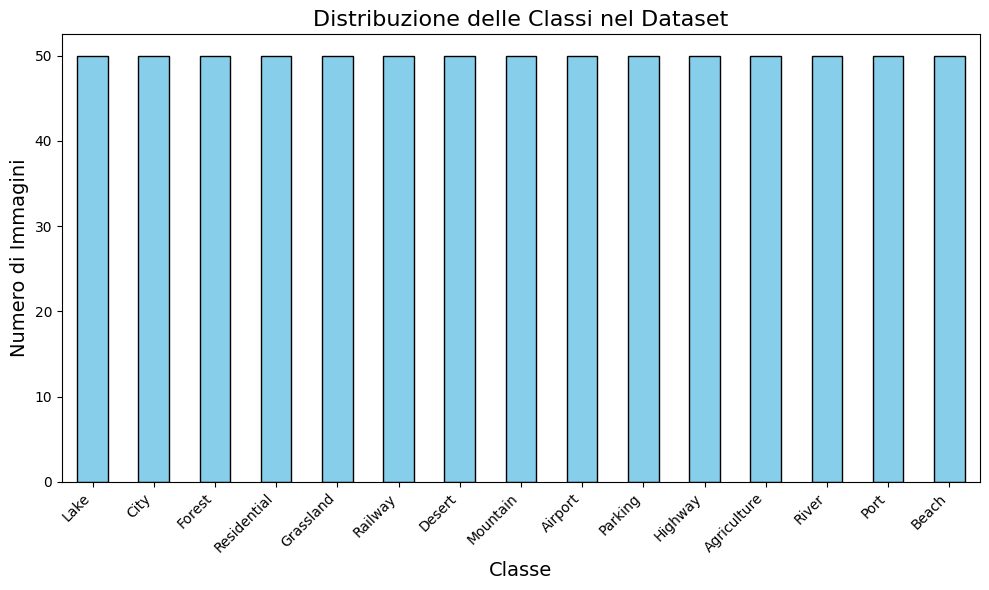

                                              Filepath        Label
0    /kaggle/input/skyview-an-aerial-landscape-data...         Lake
1    /kaggle/input/skyview-an-aerial-landscape-data...         City
2    /kaggle/input/skyview-an-aerial-landscape-data...         City
3    /kaggle/input/skyview-an-aerial-landscape-data...       Forest
4    /kaggle/input/skyview-an-aerial-landscape-data...  Residential
..                                                 ...          ...
745  /kaggle/input/skyview-an-aerial-landscape-data...         Lake
746  /kaggle/input/skyview-an-aerial-landscape-data...         Port
747  /kaggle/input/skyview-an-aerial-landscape-data...  Residential
748  /kaggle/input/skyview-an-aerial-landscape-data...       Desert
749  /kaggle/input/skyview-an-aerial-landscape-data...      Airport

[750 rows x 2 columns]


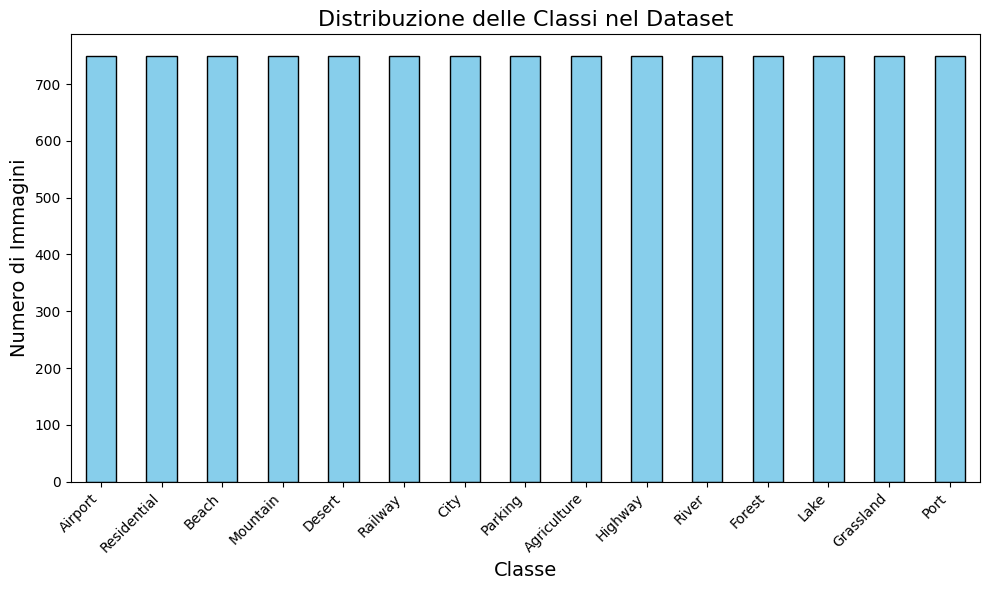

                                                Filepath        Label
0      /kaggle/input/skyview-an-aerial-landscape-data...      Airport
1      /kaggle/input/skyview-an-aerial-landscape-data...  Residential
2      /kaggle/input/skyview-an-aerial-landscape-data...      Airport
3      /kaggle/input/skyview-an-aerial-landscape-data...        Beach
4      /kaggle/input/skyview-an-aerial-landscape-data...     Mountain
...                                                  ...          ...
11995  /kaggle/input/skyview-an-aerial-landscape-data...    Grassland
11996  /kaggle/input/skyview-an-aerial-landscape-data...      Railway
11997  /kaggle/input/skyview-an-aerial-landscape-data...      Railway
11998  /kaggle/input/skyview-an-aerial-landscape-data...      Highway
11999  /kaggle/input/skyview-an-aerial-landscape-data...         Port

[11250 rows x 2 columns]


In [ ]:
# Creazione di un dataframe di 50 immagini per classe per rappresentare il test set
img_samples = 50
samples = []

# Itera sulle etichette e seleziona tutte le immagini
for category in dataset_df['Label'].unique():
    category_slice = dataset_df.query("Label == @category")

    # Campiona casualmente 50 immagini e le aggiunge alla lista
    sampled_images = category_slice.sample(img_samples, replace=False, random_state=1)
    samples.append(sampled_images)

    # Rimuove le immagini selezionate dal dataset originale
    dataset_df = dataset_df.drop(sampled_images.index)

# Unisce i dataframe campionati per creare quello di test
test_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

# Visualizza la distribuzione nel nuovo test_df
plot_class_distribution(test_df)

# Visualizza la distribuzione nel dataframe originale dopo la rimozione
plot_class_distribution(dataset_df)

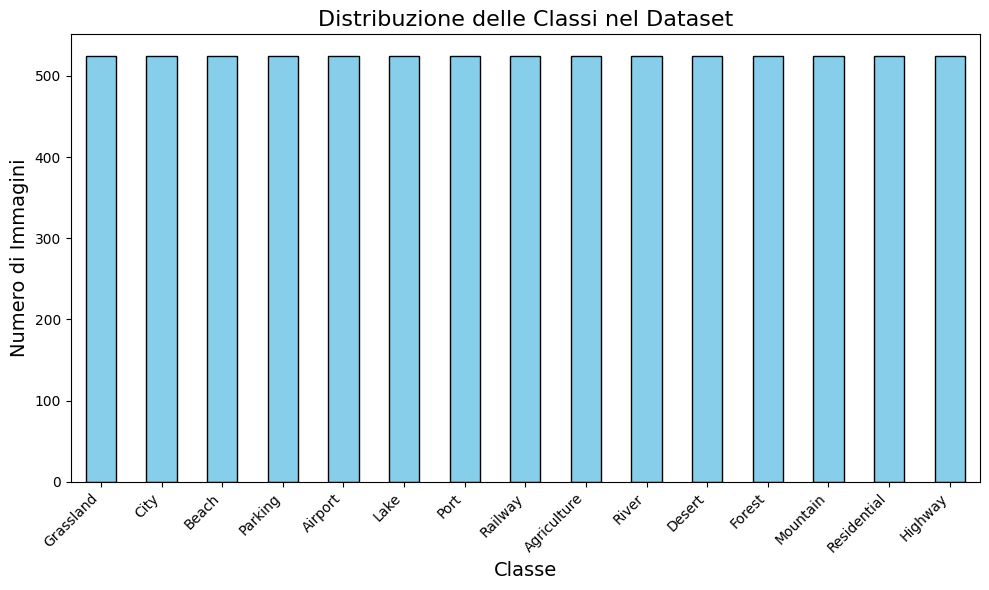

                                               Filepath      Label
5655  /kaggle/input/skyview-an-aerial-landscape-data...  Grassland
3455  /kaggle/input/skyview-an-aerial-landscape-data...       City
2515  /kaggle/input/skyview-an-aerial-landscape-data...      Beach
113   /kaggle/input/skyview-an-aerial-landscape-data...    Parking
7670  /kaggle/input/skyview-an-aerial-landscape-data...    Airport
...                                                 ...        ...
5150  /kaggle/input/skyview-an-aerial-landscape-data...     Forest
2477  /kaggle/input/skyview-an-aerial-landscape-data...    Airport
6844  /kaggle/input/skyview-an-aerial-landscape-data...     Desert
7075  /kaggle/input/skyview-an-aerial-landscape-data...       Lake
701   /kaggle/input/skyview-an-aerial-landscape-data...       Port

[7875 rows x 2 columns]


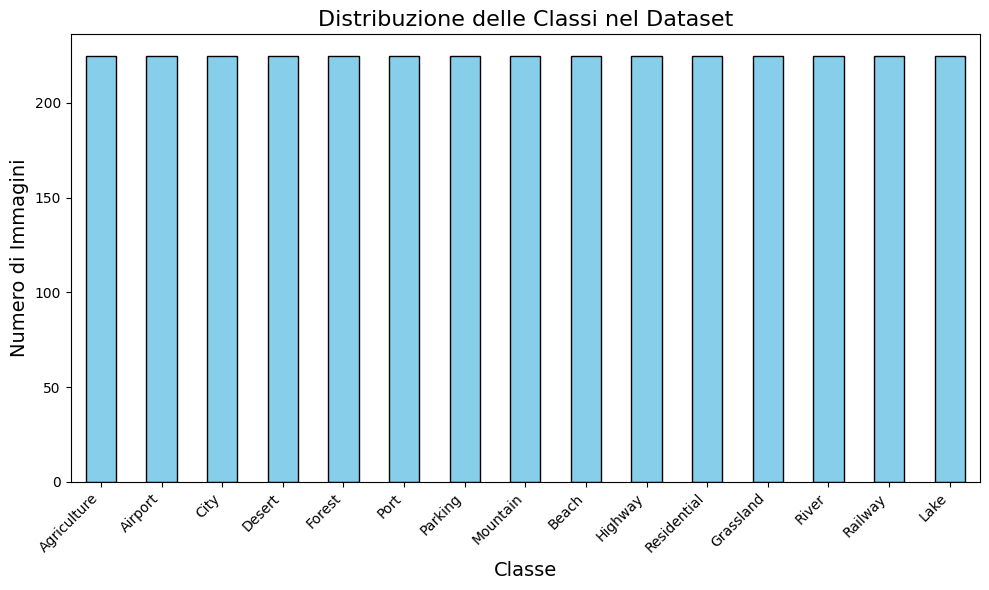

                                                Filepath        Label
1732   /kaggle/input/skyview-an-aerial-landscape-data...  Agriculture
2773   /kaggle/input/skyview-an-aerial-landscape-data...      Airport
10225  /kaggle/input/skyview-an-aerial-landscape-data...  Agriculture
7668   /kaggle/input/skyview-an-aerial-landscape-data...         City
9131   /kaggle/input/skyview-an-aerial-landscape-data...       Desert
...                                                  ...          ...
7351   /kaggle/input/skyview-an-aerial-landscape-data...       Desert
7421   /kaggle/input/skyview-an-aerial-landscape-data...        Beach
1772   /kaggle/input/skyview-an-aerial-landscape-data...      Airport
10873  /kaggle/input/skyview-an-aerial-landscape-data...      Airport
8816   /kaggle/input/skyview-an-aerial-landscape-data...      Highway

[3375 rows x 2 columns]


In [ ]:
#Suddivide il dataframe principale in training e validation
train_df, val_df = train_test_split(
    dataset_df,
    test_size=0.3,
    shuffle=True,
    stratify=dataset_df['Label'],
    random_state=45
)

plot_class_distribution(train_df)
plot_class_distribution(val_df)

##🌍 Data Augmentation

During training, **data augmentation** was applied to make the model more robust to variations and diverse scenarios.

For **validation** and **testing**, no augmentation was used — only **rescaling** — to ensure that the model is evaluated on real, unaltered images.  
In particular, the **test set** is used to assess how well the model performs on completely unseen data.


In [ ]:
img_size = (224,224)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#Chiamo il metodo flow_from_dataframe per avere un DataFrameIterator contenente batch images e etichette per ogni set
train_images = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=21
    )

#Inizializzazione di un ImageDataGenerator con augmentation per il val
valgen = ImageDataGenerator(rescale=1./255)

val_images = valgen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

#Inizializzazione di un ImageDataGenerator con augmentation per il test
testgen=ImageDataGenerator(rescale = 1./255)

test_images = testgen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7875 validated image filenames belonging to 15 classes.
Found 3375 validated image filenames belonging to 15 classes.
Found 750 validated image filenames belonging to 15 classes.


##🌍Custom Model

In [ ]:
def build_custom_model():
    model = tf.keras.models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Fully connected
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(15, activation='softmax'))

    return model

# Costruzione del modello
model = build_custom_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,739,215 (6.63 MB)

 Trainable params: 1,736,975 (6.63 MB)

 Non-trainable params: 2,240 (8.75 KB)

### Training

In [ ]:
optimizer = Adam(learning_rate=0.001)

# Compilazione del modello
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',    #Per classificazione multiclasse
    metrics=['accuracy','Precision']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/SkyViewModel/outcomes/CNN_final_result2.keras',  # Percorso su Google Drive dove verrà salvato
    verbose=1,
    monitor='val_loss',  # Monitora il val_loss
    save_best_only=True  # Salva solo il modello con il miglior val_loss
)

#Inizio addestramento
history = model.fit(train_images,
                    epochs=30,
                    validation_data = val_images,
                    callbacks=[early_stopping, checkpoint, reduce_lr]
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - Precision: 0.6482 - accuracy: 0.4482 - loss: 1.7574
Epoch 1: val_loss improved from inf to 5.49668, saving model to /content/drive/MyDrive/progetto/CNN_final_result2.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 198s 749ms/step - Precision: 0.6484 - accuracy: 0.4485 - loss: 1.7563 - val_Precision: 0.0679 - val_accuracy: 0.0667 - val_loss: 5.4967 - learning_rate: 0.0010
Epoch 2/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - Precision: 0.7542 - accuracy: 0.6081 - loss: 1.1778
Epoch 2: val_loss improved from 5.49668 to 1.73773, saving model to /content/drive/MyDrive/progetto/CNN_final_result2.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 109s 443ms/step - Precision: 0.7543 - accuracy: 0.6082 - loss: 1.1774 - val_Precision: 0.5596 - val_accuracy: 0.4684 - val_loss: 1.7377 - learning_rate: 0.0010
Epoch 3/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - Precision: 0.7903 - accuracy: 0.6836 - loss: 0.9508
Epoch 3: val_loss improved from 1.73773 to 1.38632, sa

### Performance

In [ ]:
np.save('/content/drive/MyDrive/SkyViewModel/outcomes/CNN_final_result.npy', history.history)

In [ ]:
history = np.load('drive/MyDrive/SkyViewModel/outcomes/CNN_final_result.npy',allow_pickle='TRUE').item()

acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

precision = history['Precision']
val_precision = history['val_Precision']

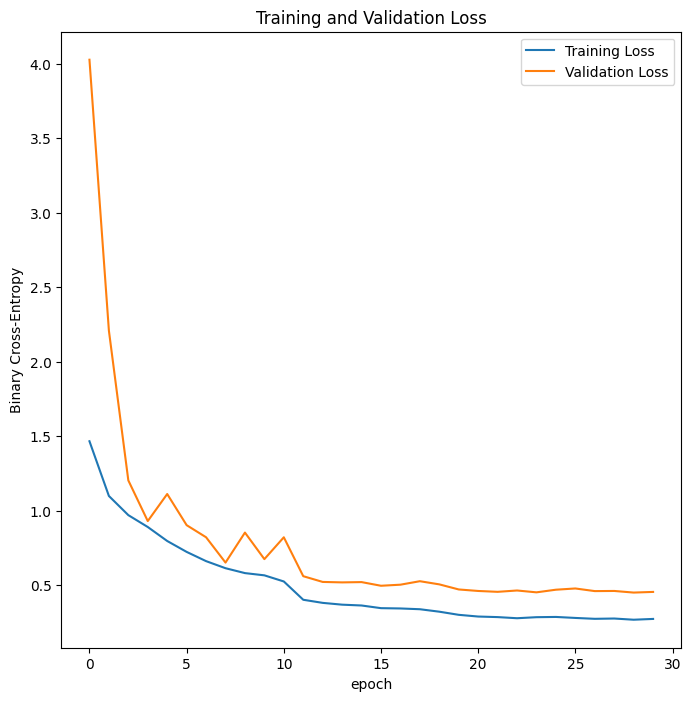

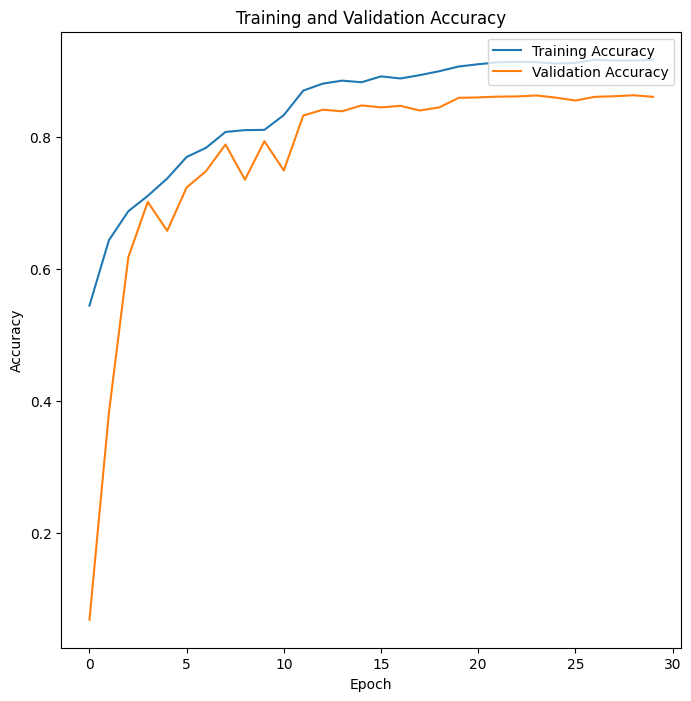

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross-Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Plotting training e validation accuracy
plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.show()

- **Training and Validation Loss:**  
  The training loss decreases consistently and steadily.  
  The validation loss initially drops but then fluctuates between epochs 5–15 before stabilizing.  
  There is no significant overfitting, although some instability can be observed in the validation loss.

- **Training and Validation Accuracy:**  
  The training accuracy increases steadily, surpassing 90%.  
  The validation accuracy reaches a plateau around 85–88%, with some fluctuations.


### Confusion Matrix

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - Precision: 0.9255 - accuracy: 0.8809 - loss: 0.3521
Test Loss: 0.3436
Test Accuracy: 0.8800
Test Precision: 0.9182
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


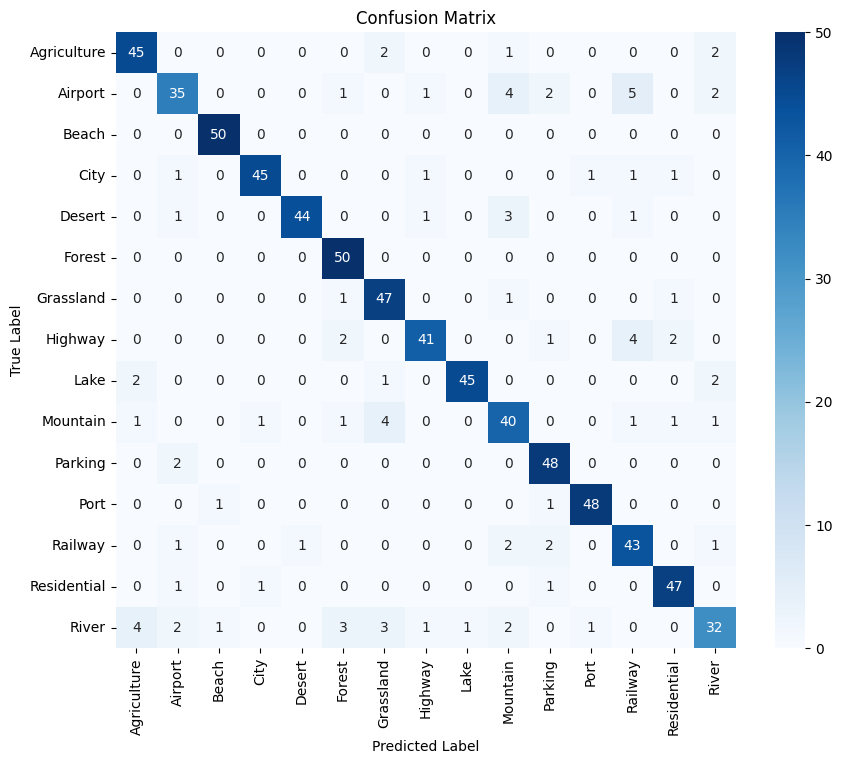

              precision    recall  f1-score   support

 Agriculture       0.87      0.90      0.88        50
     Airport       0.81      0.70      0.75        50
       Beach       0.96      1.00      0.98        50
        City       0.96      0.90      0.93        50
      Desert       0.98      0.88      0.93        50
      Forest       0.86      1.00      0.93        50
   Grassland       0.82      0.94      0.88        50
     Highway       0.91      0.82      0.86        50
        Lake       0.98      0.90      0.94        50
    Mountain       0.75      0.80      0.78        50
     Parking       0.87      0.96      0.91        50
        Port       0.96      0.96      0.96        50
     Railway       0.78      0.86      0.82        50
 Residential       0.90      0.94      0.92        50
       River       0.80      0.64      0.71        50

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88   

In [ ]:
# Carico il modello salvato
model = load_model('/content/drive/MyDrive/SkyViewModel/outcomes/CNN_final_result.keras')

# Valutazione del modello sul set di test
test_loss, test_accuracy, test_precision= model.evaluate(test_images)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")

# Predizioni sul set di test
y_pred_probs = model.predict(test_images)  # Probabilità di ogni classe
y_pred = np.argmax(y_pred_probs, axis=1)  # Converti in etichette

y_true = test_images.classes  # Etichette originali del dataset di test
class_names = list(test_images.class_indices.keys())  # Nomi delle classi


# Creazione della confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualizzazione con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

The model performs very well on classes such as **Beach**, **Forest**, **Parking**, and **Port**, achieving accuracy close to 100%.

It struggles more with visually similar classes, such as:

- **Airport**, which is often confused with **Railway**  
- **River**, which tends to be misclassified as **Agriculture** or **Forest**

This behavior is expected with aerial images, as some classes share very similar visual characteristics.


### Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


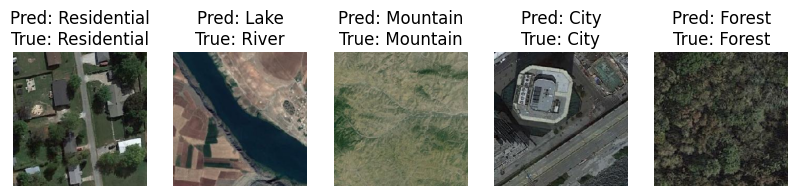

In [ ]:
# Seleziona 5 immagini casuali dal test set
sample_indices = np.random.choice(len(test_df), 5, replace=False)
selected_images = test_df.iloc[sample_indices]

# Pre-elabora le immagini
processed_images = np.array([
    img_to_array(load_img(img_path, target_size=(224, 224))) / 255.0
    for img_path in selected_images["Filepath"]
])

# Effettua la predizione
predictions = model.predict(processed_images)
predicted_labels = np.argmax(predictions, axis=1)

# Mostra le immagini con le etichette
plt.figure(figsize=(10, 5))
for i, img_path in enumerate(selected_images["Filepath"]):
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {selected_images.iloc[i]['Label']}")

plt.show()

## 🌍MobileNet

- I load a pre-trained model (MobileNetV2 with `weights='imagenet'`).
- I freeze the weights of the base model (`base_model.trainable = False`).
- I add new layers on top of the base model to adapt it to my specific 15-class classification task.

In this way, I leverage the knowledge already learned on ImageNet (a dataset with millions of images and classes) and apply it to a new task with fewer data, fewer classes, and a shorter training time.


In [ ]:
#Carica il modello MobileNetV2 pre-addestrato senza i livelli superiori
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  #Congela i pesi del modello pre-addestrato

#Creazione del nuovo modello
model_mobilenet = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(15, activation='softmax')  # Output a 15 classi
])

model_mobilenet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629,839 (10.03 MB)

 Trainable params: 370,959 (1.42 MB)

 Non-trainable params: 2,258,880 (8.62 MB)

### Training

In [ ]:
optimizer = Adam(learning_rate=0.001)

# Compilazione del modello
model_mobilenet.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',    # Per classificazione multiclasse
    metrics=['accuracy','Precision']
)

early_stopping=EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/SkyViewModel/outcomes/mobile_net_final_result2.keras',  # Percorso su Google Drive dove verrà salvato
    verbose=1,
    monitor='val_loss',  # Monitora il val_loss
    save_best_only=True  # Salva solo il modello con il miglior val_loss
)

#Addestramento del modello con i dati di training
history_mobilenet = model_mobilenet.fit(
    train_images,
    epochs=20,
    validation_data=val_images,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - Precision: 0.7119 - accuracy: 0.4845 - loss: 1.6610
Epoch 1: val_loss improved from inf to 0.48709, saving model to /content/drive/MyDrive/progetto/mobile_net_final_result2.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 132s 479ms/step - Precision: 0.7124 - accuracy: 0.4852 - loss: 1.6589 - val_Precision: 0.8897 - val_accuracy: 0.8403 - val_loss: 0.4871 - learning_rate: 0.0010
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - Precision: 0.8763 - accuracy: 0.8197 - loss: 0.5911
Epoch 2: val_loss improved from 0.48709 to 0.40551, saving model to /content/drive/MyDrive/progetto/mobile_net_final_result2.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 103s 418ms/step - Precision: 0.8763 - accuracy: 0.8196 - loss: 0.5911 - val_Precision: 0.9028 - val_accuracy: 0.8693 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - Precision: 0.8822 - accuracy: 0.8332 - loss: 0.5166
Epoch 3: val_loss improved from 0.40551 

### Performance

In [ ]:
#Salvataggio delle prestazioni del modello
np.save('/content/drive/MyDrive/SkyViewModel/outcomes/mobile_net_final_result2.npy', history_mobilenet.history)

In [ ]:
history=np.load('drive/MyDrive/SkyViewModel/outcomes/mobile_net_final_result2.npy',allow_pickle='TRUE').item()

acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

precision = history['Precision']
val_precision = history['val_Precision']

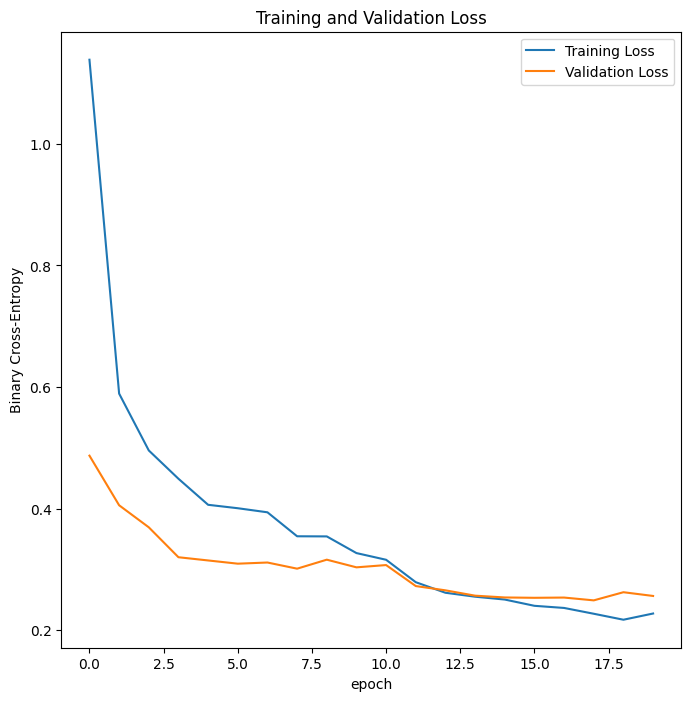

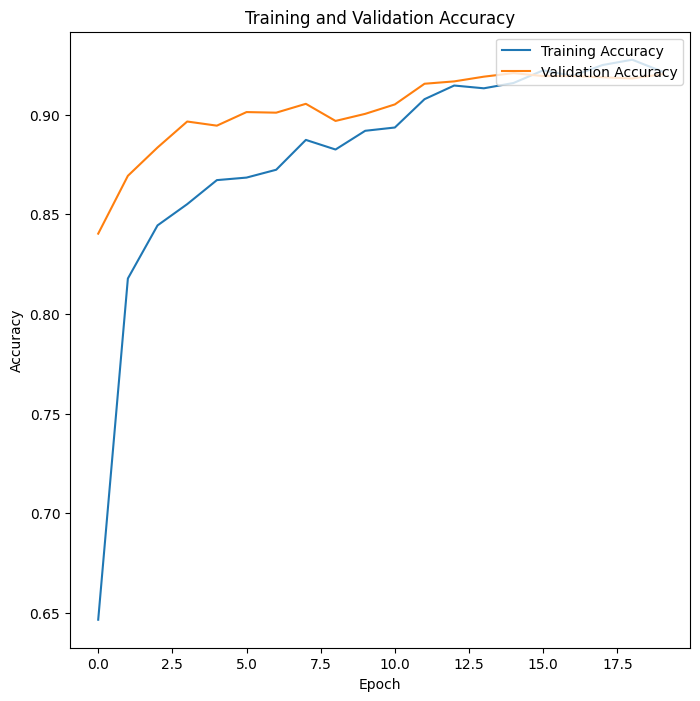

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross-Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Plotting training e validation accuracy
plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.show()

- **Training and Validation Loss:**  
  The loss decreases steadily for both sets, showing no signs of overfitting.  
  The model is learning in a balanced way.

- **Training and Validation Accuracy:**  
  Accuracy increases consistently and converges above 90%, with the validation accuracy slightly higher than the training one.  
  No overfitting is observed — the model demonstrates good generalization.


### Confusion Matrix

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - Precision: 0.9182 - accuracy: 0.9083 - loss: 0.2780
Test Loss: 0.3014
Test Accuracy: 0.9040
Test Precision: 0.9167
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step


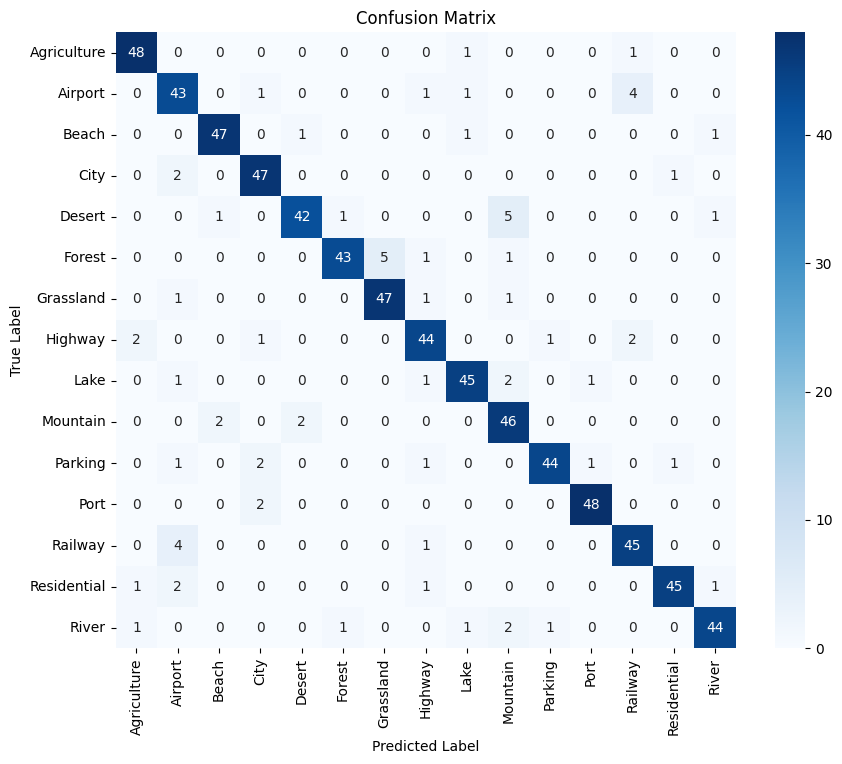

              precision    recall  f1-score   support

 Agriculture       0.92      0.96      0.94        50
     Airport       0.80      0.86      0.83        50
       Beach       0.94      0.94      0.94        50
        City       0.89      0.94      0.91        50
      Desert       0.93      0.84      0.88        50
      Forest       0.96      0.86      0.91        50
   Grassland       0.90      0.94      0.92        50
     Highway       0.86      0.88      0.87        50
        Lake       0.92      0.90      0.91        50
    Mountain       0.81      0.92      0.86        50
     Parking       0.96      0.88      0.92        50
        Port       0.96      0.96      0.96        50
     Railway       0.87      0.90      0.88        50
 Residential       0.96      0.90      0.93        50
       River       0.94      0.88      0.91        50

    accuracy                           0.90       750
   macro avg       0.91      0.90      0.90       750
weighted avg       0.91   

In [ ]:
# Carico il modello salvato
model = load_model('/content/drive/MyDrive/SkyViewModel/outcomes/mobile_net_final_result2.keras')

# Valutazione del modello sul set di test
test_loss, test_accuracy, test_precision= model.evaluate(test_images)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")

# Predizioni sul set di test
y_pred_probs = model.predict(test_images)  # Probabilità di ogni classe
y_pred = np.argmax(y_pred_probs, axis=1)  # Converti in etichette

y_true = test_images.classes  # Etichette originali del dataset di test
class_names = list(test_images.class_indices.keys())  # Nomi delle classi


# Creazione della confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualizzazione con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

The diagonal (correct predictions) is very pronounced.

Errors are mainly concentrated among visually similar classes, for example:

- **Railway** vs **Airport**  
- **Residential** vs **City**

This is caused by the visual similarities that occur from an aerial perspective.


### Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


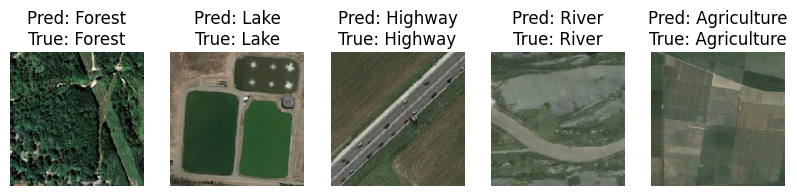

In [ ]:
# Seleziona 5 immagini casuali dal test set
sample_indices = np.random.choice(len(test_df), 5, replace=False)
selected_images = test_df.iloc[sample_indices]

# Pre-elabora le immagini
processed_images = np.array([
    img_to_array(load_img(img_path, target_size=(224, 224))) / 255.0
    for img_path in selected_images["Filepath"]
])

# Effettua la predizione
predictions = model.predict(processed_images)
predicted_labels = np.argmax(predictions, axis=1)

# Mostra le immagini con le etichette
plt.figure(figsize=(10, 5))
for i, img_path in enumerate(selected_images["Filepath"]):
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {selected_images.iloc[i]['Label']}")

plt.show()